# Creating simple multi-stock backtests using Pandas

The goal of this document is to test two multi-stock strategies, based on momentum strategies, on 10 Danish stocks. 
While backtesting.py is a wonderful tool, that creates lovely results, it is not designed with multi-stock algorithms in mind.
Therefore, this document will not use backtesting.py, instead it will rely on Pandas.

Note that these strategies are extremely simple and suffer from survivorship bias alongside selection bias.

In [193]:
# Load libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

In [ ]:
# Load data
instruments = ["NOVO-B.CO","DANSKE.CO","VWS.CO","NSIS-B.CO","ORSTED.CO","PNDORA.CO","TRYG.CO","COLO-B.CO","DSV.CO","CARL-B.CO"]

# Define the portfolio (dataframe only containing close columns)
portfolio = pd.DataFrame()

for symbol in instruments:
    # Download data with yf
    df = yf.download(symbol, start="2016-08-01", auto_adjust=True) # The start date is due to Ørsted A/S having no data before the date
    # Populate the portfolio
    portfolio[symbol] = df["Close"]

In [ ]:
# Define the log returns
log_r = np.log(portfolio / portfolio.shift(1))
# Define monthly returns
ret_m = log_r.resample('M').sum()

## Implementing the long-short cross-sectional momentum strategy

I have chosen one of the simplest strategies for this kind of portfolio. The goal here is not to showcase a complex strategy, but simply to implement a strategy with Pandas. Even the allocation of longs vs. shorts is arbitrary, and could very well be optimized instead.
If you wanted to optimize the allocation of shorts and longs, i would suggest using more stocks and eliminating survivorship bias.

In [ ]:
# First we rank each stock based on their comparative returns
rank = ret_m.rank(1, ascending=False, method='first')
# We want to go long on the top 8, and go short on the bottom 2, therefore we need the proper signals:
signal = rank.applymap(lambda x: 0.1 if x <= 8 else -0.1)
signals_shifted = signal.shift(1).fillna(0)

In [197]:
# Calculate returns
m_returns = ((np.exp(ret_m)-1)*signals_shifted).sum(axis=1)
total_returns = (1+m_returns).cumprod()

In [198]:
# Create a benchmark
benchmark = ((np.exp(ret_m)-1)*0.1).sum(axis=1)
bench_equity = (1+benchmark).cumprod()

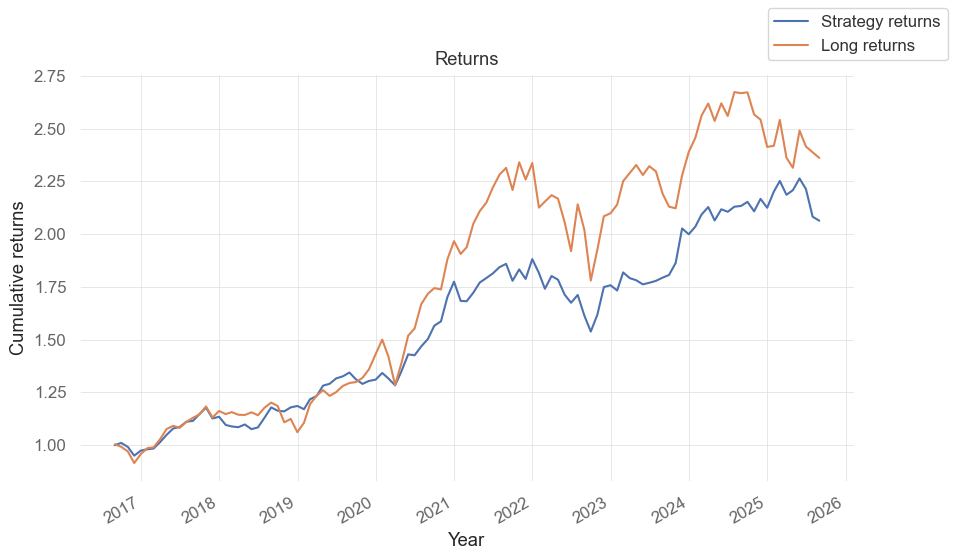

In [199]:
# Visualizing the total returns
fig, ax = plt.subplots()
ax.plot(total_returns, label='Strategy returns')
ax.plot(bench_equity, label="Long returns")
ax.set(title= "Returns",
       xlabel = "Year",
       ylabel = "Cumulative returns")
fig.autofmt_xdate()
fig.legend()

In [200]:
# Computing the standard metrics
qs.reports.metrics(m_returns, benchmark, mode='basic', periods_per_year=12)

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2016-08-31   2016-08-31
End Period           2025-08-31   2025-08-31
Risk-Free Rate       0.0%         0.0%
Time in Market       100.0%       100.0%

Cumulative Return    135.15%      106.37%
CAGR﹪               0.31%        0.26%

Sharpe               0.71         0.85
Prob. Sharpe Ratio   98.15%       99.5%
Sortino              1.13         1.46
Sortino/√2           0.8          1.03
Omega                1.85         1.85

Max Drawdown         -23.93%      -18.23%
Max DD Date          2022-09-30   2022-09-30
Max DD Period Start  2021-11-30   2022-01-31
Max DD Period End    2023-11-30   2023-10-31
Longest DD Days      731          639

Gain/Pain Ratio      0.68         0.85
Gain/Pain (1M)       0.68         0.85

Payoff Ratio         0.89         1.02
Profit Factor        1.68         1.85
Common Sense Ratio   2.19         2.27
CPC Index            0.93         1.2
Tail Ratio  

## Weighing the allocations based on volatility

In order to compare different strategies, i will implement a modification to our original strategy.
The idea here is to reduce the weight of each signal by their rolling 12 month volatility. We then normalize to ensure that we do not gain more than 100% exposure. I got the idea for this modification from ChatGPT. If one was more interested in the strategy, a good idea here would be exploring some articles written about momentum strategies.

In [201]:
# Calculate 12 month rolling volatility
rol_vol = ret_m.rolling(window=12).std()

# Create raw weights
raw_weights = signal/rol_vol

# Create the normalization divisor
norm_div = raw_weights.abs().sum(axis=1)

# Finally create the weights.
weights = raw_weights.div(norm_div, axis=0)
pos_vol = weights.shift(1).fillna(0)

In [202]:
# Repeat the results calculations, using new weights.
# Calculate returns
m_returns2 = (np.exp(ret_m)-1)*pos_vol

# Creating a column with the total returns
strat_returns2 = m_returns2.sum(axis='columns')
total_returns2 = (1+strat_returns2).cumprod()

In [203]:
# Before we can compare, we need all strategies to start at the same time
orig_ret = m_returns.iloc[12:]
bench_ret = benchmark.iloc[12:]

cum_orig = (1+orig_ret).cumprod()
cum_bench = (1+bench_ret).cumprod()

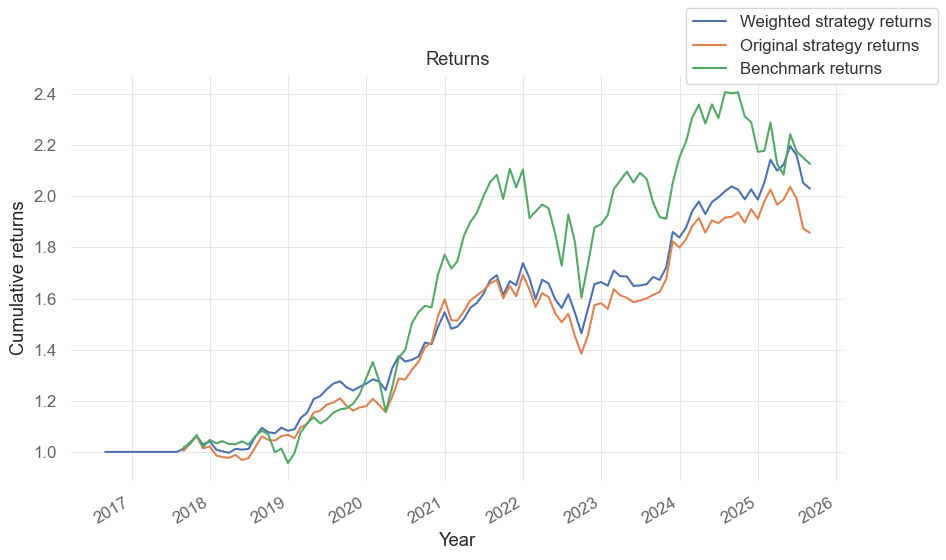

In [204]:
# Visualizing the total returns
fig, ax = plt.subplots()
ax.plot(total_returns2, label='Weighted strategy returns')
ax.plot(cum_orig, label="Original strategy returns")
ax.plot(cum_bench, label="Benchmark returns")
ax.set(title= "Returns",
       xlabel = "Year",
       ylabel = "Cumulative returns")
fig.autofmt_xdate()
fig.legend()

In [205]:
# Compute the metrics:
qs.reports.metrics(strat_returns2, cum_bench, mode='basic', periods_per_year=12)

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2016-08-31   2016-08-31
End Period           2025-08-31   2025-08-31
Risk-Free Rate       0.0%         0.0%
Time in Market       88.0%        88.0%

Cumulative Return    106.07%      95.77%
CAGR﹪               0.26%        0.25%

Sharpe               0.63         0.86
Prob. Sharpe Ratio   96.78%       99.58%
Sortino              0.99         1.54
Sortino/√2           0.7          1.09
Omega                1.94         1.94

Max Drawdown         -23.93%      -15.78%
Max DD Date          2022-09-30   2022-09-30
Max DD Period Start  2021-11-30   2022-01-31
Max DD Period End    2023-11-30   2023-10-31
Longest DD Days      731          639

Gain/Pain Ratio      0.63         0.94
Gain/Pain (1M)       0.63         0.94

Payoff Ratio         0.97         1.25
Profit Factor        1.63         1.94
Common Sense Ratio   2.12         2.29
CPC Index            0.96         1.45
Tail Ratio  

In [206]:
# Let us visualize the equity impact of both strategies. Let us assume that making a trade reduces equity by 0.5% of the turnover
w_eq = signals_shifted.div(signals_shifted.abs().sum(axis=1), axis=0)
turn_eq = w_eq.diff().abs().sum(axis=1).fillna(0)
cost_eq = 0.0005*turn_eq # Note that the transaction cost of 0.5% is completely arbitrary
equity = (1+orig_ret-cost_eq).cumprod()


turn_vol = pos_vol.diff().abs().sum(axis=1).fillna(0)
cost_vol = 0.0005*turn_vol
equity2  = (1+strat_returns2-cost_vol).cumprod()

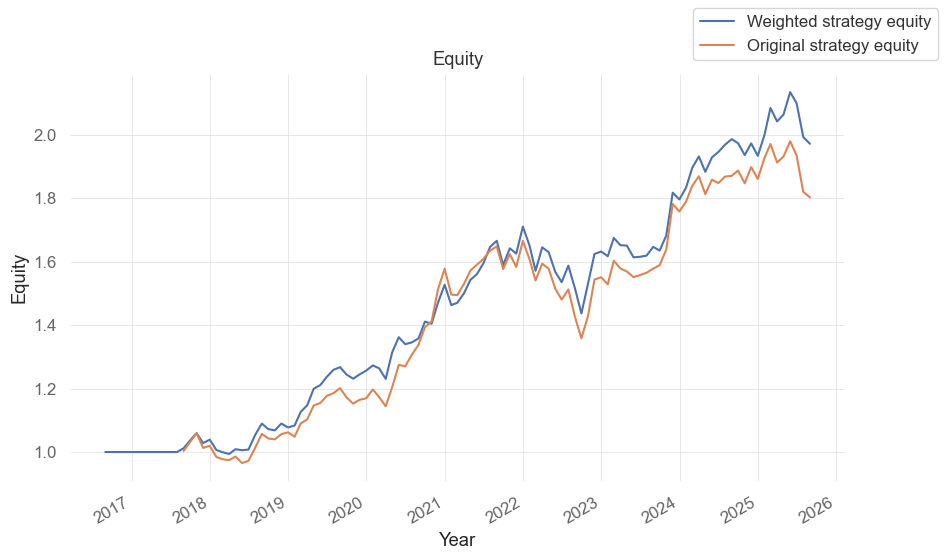

In [207]:
# Visualizing the equity return of both strategies after applying transaction costs
fig, ax = plt.subplots()
ax.plot(equity2, label='Weighted strategy equity')
ax.plot(equity, label="Original strategy equity")
ax.set(title= "Equity",
       xlabel = "Year",
       ylabel = "Equity")
fig.autofmt_xdate()
fig.legend()

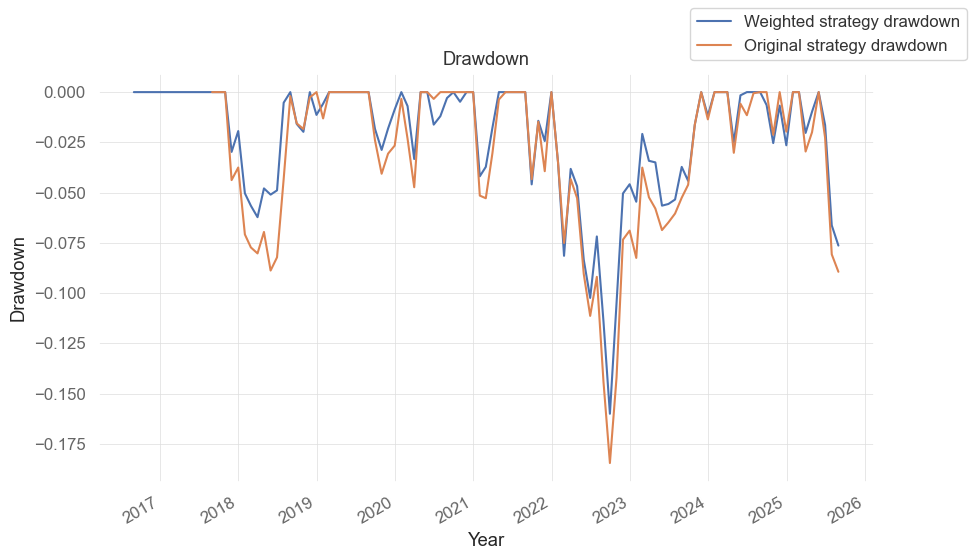

In [208]:
# Visualizing drawdown
drawdown = equity/equity.cummax()-1
drawdown2 = equity2/equity2.cummax()-1

fig, ax = plt.subplots()
ax.plot(drawdown2, label='Weighted strategy drawdown')
ax.plot(drawdown, label="Original strategy drawdown")
ax.set(title= "Drawdown",
       xlabel = "Year",
       ylabel = "Drawdown")
fig.autofmt_xdate()
fig.legend()